## Tutorial A5: Annotations

> TOMTOM/FIMO

When we talk about using machine learning models to discover biological principles, in many settings the machine learning models are not the final product. Rather, discovering the building blocks that drive model predictions and the syntax of these building blocks can be far more informative for understanding the genome and also doing downstream design. These building blocks are called "annotations" and are a superset of seqlets, which are contiguous spans of high-attribution characters (although the precise definition might change across methods), FIMO hit calls, which are motif matches based on a PWM that only account for the sequence content and do not care about attributions, and Contribution-Weight Matrix (CWM)-based hits that account for both sequence content and attribution weight (contribution and attribution are mostly synonymous). Basically, an annotation here has the same meaning as it does when talking about genes/genomes -- it is a start position, an end position, and optionally a label as to what is happening there.

Let's start off by loading the Beluga model, creating a synthetic sequence that has two AP-1 motifs in it and an ETV6 motif, and calculating attributions. After calculating attributions, we are done with the Beluga model!

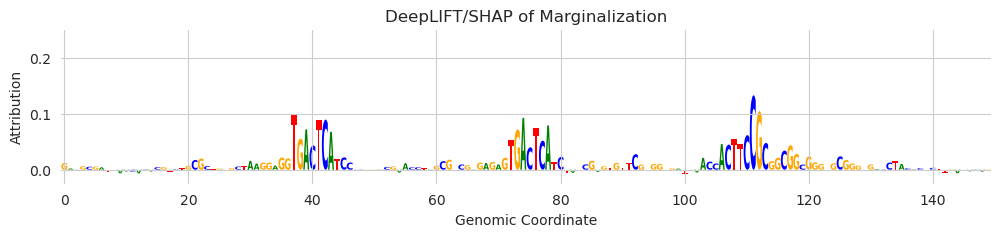

In [1]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

import numpy
import torch
from model import Beluga

from tangermeme.utils import random_one_hot
from tangermeme.ersatz import multisubstitute
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.plot import plot_logo

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)  
X = multisubstitute(X, ["GTGACTCATC", "GTGACTCATC", "ACTTCCGCG"], [25, 25])
X_attr = deep_lift_shap(model, X, device='cpu', n_shuffles=20, target=57, random_state=0)

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 925:1075], ax=ax)
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

#### Deriving Annotations from Seqlets

Annotations are represented in tangermeme as a three-column tensor of indexes that reference a tensor of sequences. Basically, if `X` is a one-hot encoded tensor of sequences with shape `(n_examples, len(alphabet), length)`, then `X_annotations` will be a three column tensor of shape `(n_annotations, 3)` where the first column is the example_idx in `X`, the second column is the start position (0-indexed), and the third column is the end position (also 0-indexed). 

In [2]:
from tangermeme.seqlet import recursive_seqlets

seqlets = recursive_seqlets(X_attr.sum(dim=1), additional_flanks=5)
seqlets.shape

(5, 5)

At this point, we have coordinates but we might not know what is really happening at these positions. Are these seqlets known motifs? Have we discovered something new?

We can look into this more by mapping each seqlet to a known database of motifs using TOMTOM. Please see the tutorial on TOMTOM if you'd like to know more about it, and how to use it directly, but at a high level it is an algorithm for mapping one set of PWMs to another set of PWMs and finding statistically significant matches. Here, one of our sets of PWMs is one-hot encoded -- the sequences under the seqlets -- but the algorithm is still valuable because it properly constructs background distributions, accounts for sequence length and information content, and handles overhangs.

We can do this mapping using the `annotate_seqlets` command. This command takes the original one-hot encoded sequences, the set of seqlets, and a motif database (either a dictionary where keys are motif names and values are PWMs or a filename of a MEME-formatted file) and outputs the motif index (or indexes) that best match/es each seqlet.

In [3]:
from tangermeme.annotate import annotate_seqlets

annotate_seqlets(X, seqlets, "motifs.meme.txt")

(tensor([[ 639],
         [1243],
         [1743],
         [ 357],
         [1295]], dtype=torch.int32),
 tensor([[3.8022e-05],
         [2.3365e-05],
         [7.1939e-04],
         [5.6394e-06],
         [8.7449e-06]], dtype=torch.float64))

There are two outputs: the index in the motif database of the best match and the p-value for that match. It looks like all of the matches have a pretty high p-value. 

In [4]:
from tangermeme.io import read_meme

motifs = read_meme("motifs.meme.txt")
motif_names = list(motifs.keys())
motif_idxs, motif_pvalues = annotate_seqlets(X, seqlets, motifs)

[motif_names[idx] for idx in motif_idxs]

['Jdp2.mouse_bZIP_1',
 'ETV6_MA0645.1',
 'VENTX_MA0724.1',
 'FOS_MOUSE.H11MO.0.A',
 'JUND_MA0491.1']

Looks like we have two AP-1 hits (the last two are both AP-1 family, even though the names are different) and then other hits for the other motifs. It also looks like the ETV6 motif is found.

If we wanted to visualize this better, we could make a copy of the seqlets dataframe, change the names in the first column to be the discovered motif matches, and use the `plot_logo` command again.

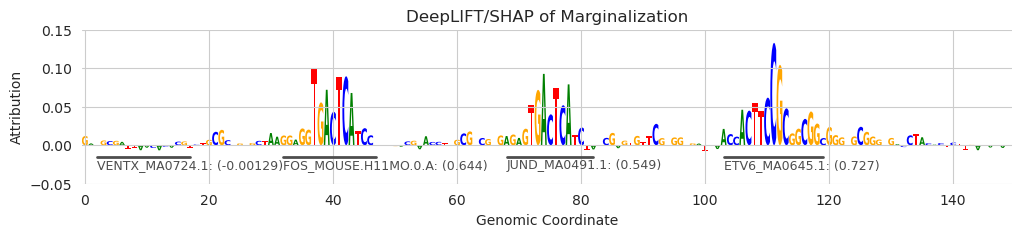

In [5]:
seqlet_annotations = seqlets.copy()
seqlet_annotations['example_idx'] = [motif_names[idx] for idx in motif_idxs]

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=seqlet_annotations, score_key='attribution', ylim=0.15)
plt.ylim(-0.05, 0.15)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

As expected, the seqlets called over the inserted AP-1 motifs now match to AP-1 in the database and the one corresponding to ETV6 is called ETV6! At this point, we now have annotations in the sense that we have the seqlet coordinates and, for each seqlet, we have an assignment to a motif.

Note that no motif discovery was done here. The only steps that were performed were calculating attributions, calling seqlets, and mapping those seqlets to a known database to get labels for the annotations. Importantly, the seqlet calling step is done entirely on attributions with no knowledge of sequence content, and the mapping to a database is done only on sequence content with no knowledge of the attributions.

Sometimes, you would like to map a seqlet to multiple patterns to see whether there are any other closely related hits. The `annotate_seqlets` function is mostly a wrapper around running TOMTOM and so you can pass any argument into it and they will be passed along to TOMTOM. For instance, you can pass `n_nearest=5` and you will get the five best motif matches for each motif ranked by the p-value.

In [6]:
annotate_seqlets(X, seqlets, "motifs.meme.txt", n_nearest=5)

(tensor([[ 639, 1364,  578,  707,  210],
         [1243,  786, 1269,  952,  130],
         [1743, 1142,  686, 1582, 1285],
         [ 357, 1295, 1075, 1203, 1005],
         [1295,  707,  210,  639, 1364]], dtype=torch.int32),
 tensor([[3.8022e-05, 6.7897e-05, 6.7897e-05, 7.7329e-05, 7.7329e-05],
         [2.3365e-05, 2.3365e-05, 1.2413e-04, 1.2689e-04, 1.3772e-04],
         [7.1939e-04, 7.1939e-04, 2.2012e-03, 2.3998e-03, 2.7296e-03],
         [5.6394e-06, 7.7946e-06, 1.0170e-05, 1.0848e-05, 1.0848e-05],
         [8.7449e-06, 1.7248e-05, 1.7248e-05, 2.0561e-05, 2.3947e-05]],
        dtype=torch.float64))

#### FIMO-based Annotations

An orthogonal way to calculate annotations is to run FIMO, which scans a set of PWMs against explicitly one-hot encoded sequences. A strength of this approach is that it does not rely on a seqlet calling algorithm, which can be imprecise or yield noisy seqlets. However, a weakness of this approach is that it does not natively consider attributions at all, although one can sum the attribution values across the identified hits after those spans are identified. Another important point is that this algorithm does not account for edge overhangs as well as TOMTOM and so is not the best algorithm to use with seqlets, but does account for motif length and information content. Overall, if one wants to run a database of motifs against long sequences to identify sequence hits and then subsequently score each hit using attributions, this is a simple approach.

In [7]:
from tangermeme.tools.fimo import fimo

hits = fimo("motifs.meme.txt", X, dim=1)[0]
hits

/users/jmschr/github/tangermeme/tangermeme/tools/fimo.py:367: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hits = pandas.concat(hits)


,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value
0,DNASE_6,0,0,1831,1861,+,11.908878,0.000049
1,DNASE_2,4,0,1831,1861,+,12.146909,0.000012
2,TN5_7,8,0,1424,1454,+,12.363324,0.000010
3,TN5_5,9,0,1746,1776,-,12.449126,0.000010
4,TN5_4,10,0,1746,1776,-,12.449126,0.000010
...,...,...,...,...,...,...,...,...
898,ZIC3_MA0697.1,2170,0,81,96,+,8.837521,0.000074
899,ESR2_MA0258.2,2171,0,1045,1060,-,12.674289,0.000026
900,EPAS1_MOUSE.H11MO.0.C,2181,0,167,176,+,11.515308,0.000069
901,BACH1_MOUSE.H11MO.0.C,2184,0,993,1007,-,4.745783,0.000022


A challenge with this approach is that, as you can see, there will usually be hundreds of hits to each sequence. Hence, the next step is usually to extract attribution values for each hit.

In [8]:
hits['attribution'] = [X_attr[0, :, start:end].sum().item() for start, end in hits[['start', 'end']].values]
hits = hits.sort_values("attribution")
hits

,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value,attribution
325,HIF1A_MA1106.1,721,0,167,177,+,13.151028,0.000004,-0.035880
174,TEAD1_MOUSE.H11MO.0.A,390,0,174,185,-,11.532274,0.000061,-0.034053
614,EPAS1_HUMAN.H11MO.0.B,1362,0,167,176,+,11.515308,0.000069,-0.032816
900,EPAS1_MOUSE.H11MO.0.C,2181,0,167,176,+,11.515308,0.000069,-0.032816
717,ARNT_HUMAN.H11MO.0.B,1658,0,167,176,+,11.572852,0.000057,-0.032816
...,...,...,...,...,...,...,...,...,...
210,FLI1_MOUSE.H11MO.0.A,475,0,1029,1043,-,13.670665,0.000014,0.677990
50,GABPA_MOUSE.H11MO.0.A,130,0,1029,1043,-,15.298798,0.000004,0.677990
233,ETS1_MOUSE.H11MO.0.A,536,0,1029,1043,-,12.022456,0.000041,0.677990
574,ELF1_MOUSE.H11MO.0.A,1269,0,1029,1043,-,15.052783,0.000005,0.677990


If we want to take a more comprehensive view of the attribution scores, we can plot this score in ascending order.

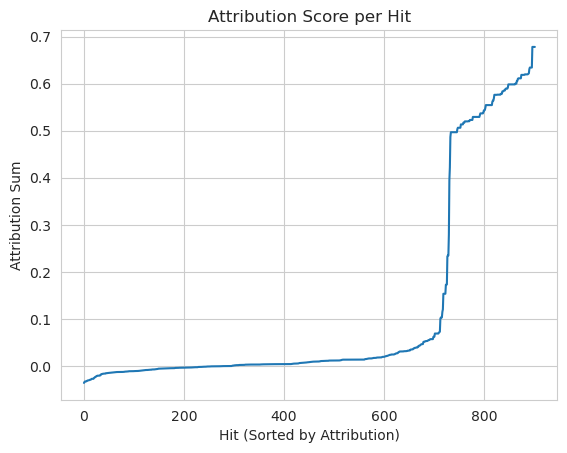

In [9]:
plt.plot(hits['attribution'].values)
plt.xlabel("Hit (Sorted by Attribution)")
plt.ylabel("Attribution Sum")
plt.title("Attribution Score per Hit")
plt.show()

It looks like most of the motifs have low attribution but that there is a sudden jump in score that lasts for over 100 of the hits. Fortunately, this is not because there are over 100 distinct motif instances that have high attribution -- because we generated our sequence synthetically, we know that is not the case! What it does mean, though, is that there are many FIMO hits that overlap each other, and in some cases are actually identical. This is because some motif databases are full of redundant or even identical motifs. Sometimes this is because the same protein has been profiled multiple times, but usually it is because multiple proteins (potentially in the same family) have the same DNA binding domain and so actual bind in very similar or identical places along the genome. You can see this in the dataframe just above, where all five of the bottom motifs seem to have hits at the exact same coordinates.

#### Counting Annotations

Now that we have two methods for getting annotations, we need methods for operating on sets of annotations. The simplest one is to count the number and type of annotations per example so that one can get a sense globally for what annotations are influential at all. This function, `count_annotations`, will take in either a tensor with the example index and the annotation index as columns, or a tuple where the first vector is the example indexes and the second vectro is the annotation indexes, and return a matrix of size `(n_examples, n_annotations)` that has the count of the number of annotations in each sequence.

We can use either the seqlet calling + TOMTOM annotations or the FIMO annotations here. Each one will require a small amount of preprocessing. For the seqlet calling + TOMTOM annotations, we need to concatenate the sequence index (from the seqlet caller) with the annotation index (from the annotation function).

In [10]:
from tangermeme.annotate import count_annotations

y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]))
y.shape

torch.Size([1, 1744])

Since we only have a single example, the first dimension is just that one example, and the second dimension is the maximum observed annotation index in the set of indexes. If we are concerned that we might not see the highest index annotation in our set, and know what either dimension should be beforehand, we can pass that shape in.

In [11]:
y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]), shape=(3, len(motif_names)))
y.shape, y.dtype

(torch.Size([3, 2193]), torch.uint8)

Regardless, the tensor should sum to the number of seqlets/annotations that were being used.

In [12]:
y.sum()

tensor(5)

Note that this count matrix is likely to be extremely sparse and that, as the number of examples grows to be very large, this tensor will take up a large amount of space. That is why by default the dtype for the tensor it uint8. This decreases the amount of space taken up significantly, although it does cap the number of counts of each annotation in each example that are possible. If you want to change the dtype you can just pass that in.

In [13]:
y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]), dtype=torch.float32) 
y.shape, y.dtype

(torch.Size([1, 1744]), torch.float32)

One might wonder if it were possible to return a sparse matrix instead of a dense matrix. But.. the two vectors being passed in *are* a sparse matrix, even if all the matrix operations aren't yet wrapped around it. If you really need a sparse matrix, you can easily create a `scipy.sparse.coo` or PyTorch sparse tensor.

In lieu of complete sparse tensor support, you can get sums along either of the two dimensions without instantiating the entire tensor. If you want the total number of times an annotation is seen you can use `dim=0`, and if you want the total annotations per example, you can use `dim=1`. This follows from what you would pass into `torch.sum` if you wanted to reduce the full tensor into one of those dimensions.

In [14]:
y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]), dim=0) 
y.shape, y.dtype

(torch.Size([1744]), torch.uint8)

In [15]:
y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]), dim=1) 
y.shape, y.dtype

(torch.Size([1]), torch.uint8)

This functionality provides a simple way to explore what a machine learning model has learned. First, calculate attributions and call seqlets. Then, rather than using those seqlets to do de novo pattern discovery with TF-MoDISco, which may be robust but also overkill if you just want to inspect the general concepts learned by the model, you simply map those seqlets to some database of known motifs. Finally, you count the number of times each annotation shows up in your database. 

Here is the entirety of the code.

In [16]:
model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

motifs = read_meme("motifs.meme.txt")
motif_names = numpy.array(list(motifs.keys()))

X_attr = deep_lift_shap(model, X, device='cpu', n_shuffles=20, target=57, random_state=0)

seqlets = recursive_seqlets(X_attr.sum(dim=1), additional_flanks=5)
motif_idxs, _ = annotate_seqlets(X, seqlets, motifs)

y = count_annotations((seqlets['example_idx'], motif_idxs[:, 0]), shape=(1, len(motif_names)), dim=0)
motif_names[y > 0]

array(['FOS_MOUSE.H11MO.0.A', 'Jdp2.mouse_bZIP_1', 'ETV6_MA0645.1',
       'JUND_MA0491.1', 'VENTX_MA0724.1'], dtype='<U29')

In just a few seconds and a few lines of code, we can pull out the three motifs that we added to the sequence (plus the two negative seqlets that have been discussed in the seqlet tutorial). 

So far, we have focused on seqlet calling + TOMTOM for our set of annotations. But, as mentioned earlier, we can also use FIMO + attribution thresholding to get a set of annotations. Remember that there were many hundreds of motif matches when just running FIMO against the randomly generated sequence.

In [17]:
hits.shape

(903, 9)

An initial step we can take is to filter these 903 hits down using attribution scores -- basically, say that a motif hit must also have some amount of attribution within it to be kept. This will remove spurious motif htis that are not thought to be relevant by the model.

In [18]:
hits_thresh = hits[hits['attribution'] > 0.5]
hits_thresh.shape

(156, 9)

Even with a fairly stringest attribution threshold, we are still getting over a hundred motif hits! Why is this happening? Well, to get a sense for that, let's take a look at the region where we substituted in the three motifs.

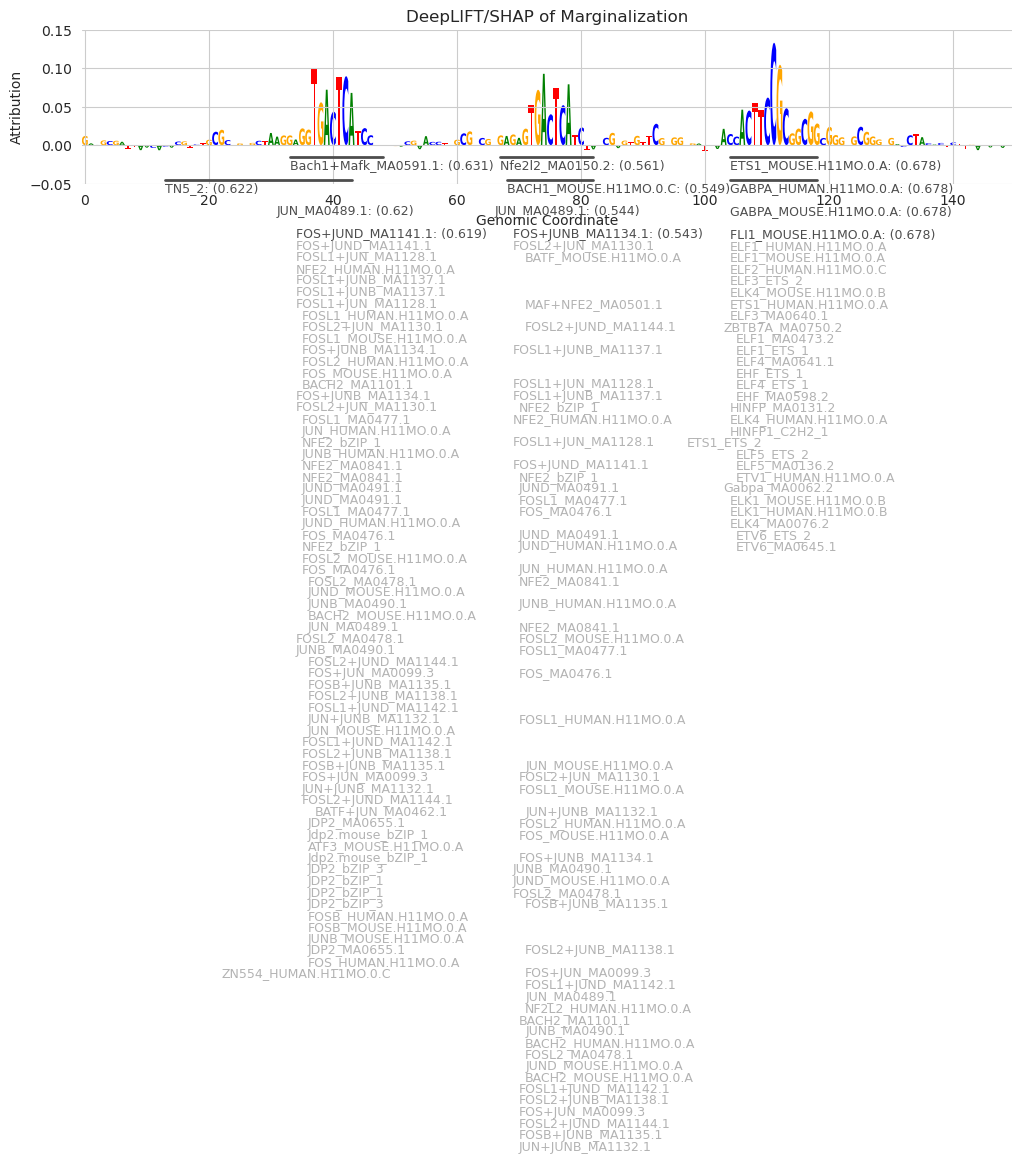

In [19]:
plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=hits_thresh, score_key='attribution', ylim=0.15)
plt.ylim(-0.05, 0.15)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Well.. that looks like a lot of motifs mapping to the same region. But this makes sense because the JASPAR database we are using as our motif collection is extremely redundant. Each motif in it is not a unique PWM, but rather is the output from a single experiment and these experiments may evaluate proteins whose DNA binding properties are similar. This means that it is not simple to determine which of these proteins is actually binding to the site. After all, the one with the highest p-value or the highest attribution sum across the span might be best by only a tiny amount that is driven more by experimental noise than by real biology. Because many proteins could potentially be binding to this site, one may not want to toss aside matches.

An important point is that the seqlet calling + TOMTOM approach only *appears* to avoid this issue but does not *actually* avoid the issue. Because we constrain the number of matches that TOMTOM returns, we definitionally only get that number of matches even when there are others that have similarly significant hits.

Regardless of these points, we can still use the same `count_annotations` function as before to get a similar matrix. Remember, it does not matter how you get your annotations -- you can even define them by hand!

In [20]:
y = count_annotations((hits_thresh['sequence_name'].astype(int), hits_thresh['motif_idx']))
y.shape, y.sum()

(torch.Size([1, 2185]), tensor(156))

#### Pairwise Annotations

Having a count of the number of annotations per example, or an aggregation across either of the two axes, can be useful as a first glance at what is being picked up by the model. Another level of understanding is looking at what pairs of annotations co-occur in sequences. This starts to delve into the more complex syntax underlying the annotations. After all, if a pair of motifs frequently co-occurs, that may indicate either a shared regulatory code or that multiple regulatory codes must use the same region. Regardless, something to look into!

You can calculate a square matrix of pairwise annotations using the `pairwise_annotations` function, which has the same required signature as `count_annotations`. This function will return a square matrix that is symmetric and the total counts is equal to twice the number of *pairs* in the data set minus those on the diagonal. Basically, an interaction between index 5 and index 7 is counted in both `y[5, 7]` and `y[7, 5]`, but an interaction between index 5 and 5 is only counted once in `y[5, 5]`. This means that taking the upper or lower triangles will yield a matrix whose sum is equal to the number of pairs in the data.

In [21]:
from tangermeme.annotate import pairwise_annotations

y = pairwise_annotations((seqlets['example_idx'], motif_idxs[:, 0]))
y.shape, y.sum()

(torch.Size([1744, 1744]), tensor(20))

We cannot easily visualize a (1744, 1744) sized matrix, but we can filter out the rows and columns with no interactions and visualize that.

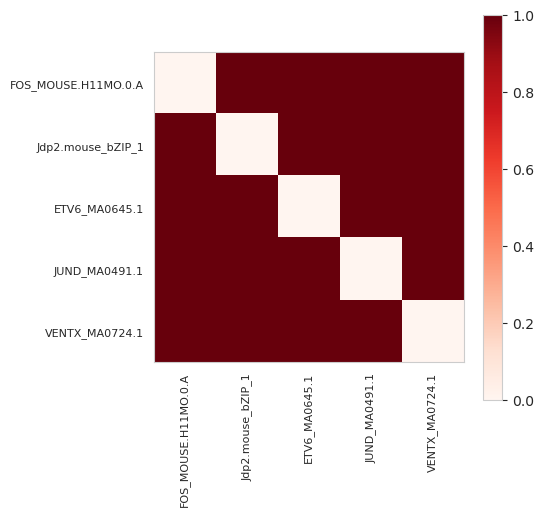

In [22]:
r_idxs = y.sum(dim=1) > 0
c_idxs = y.sum(dim=0) > 0

plt.figure(figsize=(5, 5))
plt.imshow(y[r_idxs][:, c_idxs], cmap='Reds', vmin=0, vmax=1)
plt.xticks(range(5), motif_names[:1744][c_idxs], rotation=90, fontsize=8)
plt.yticks(range(5), motif_names[:1744][r_idxs], fontsize=8)
plt.grid(False)
plt.colorbar()
plt.show()

Remember that there were five annotations and each were of a different motif. Hence, the sum of this matrix is 20 which is twice the number of pairs (for 5, there are (5*4)/2=10 pairs) minus the sum of the diagonal, which is zero, because there are no repeated annotations.

In some situations, what we actually want is an *ordered* matrix where the counts are structured such that the row index is the annotation that appears earlier in the list and the column index is later in the list. Reconsider the annotations we have: 

In [23]:
motif_names[motif_idxs[:, 0]]

array(['Jdp2.mouse_bZIP_1', 'ETV6_MA0645.1', 'VENTX_MA0724.1',
       'FOS_MOUSE.H11MO.0.A', 'JUND_MA0491.1'], dtype='<U29')

When we consider the ordering, that is saying that we want `y[Jdp2..., ETV6...] = 1` but not the inverse, and then we want `y[Jdp2..., VENTX...] = 1`, etc. Then, we want `y[ETV6..., VENTX...] = 1` without setting `y[ETV6..., Jdp2...] = 1`. Again, we only count interactions between annotations and annotations that come after them in the ordering in the same example. Since we separate out annotations by example index, this still does not create pairs across example boundaries and so the example order doesn't matter, but within each example the order matters. 

We can calculate this ordered pairwise matrix by setting `symmetric=False`.

In [24]:
y = pairwise_annotations((seqlets['example_idx'], motif_idxs[:, 0]), symmetric=False)
y.shape, y.sum()

(torch.Size([1744, 1744]), tensor(10))

Now, we can see that `y` has the same shape but it has half the contacts. This is because contacts are not copied across the diagonal to force symmetry.

Let's take a look at what the returned matrix looks like:

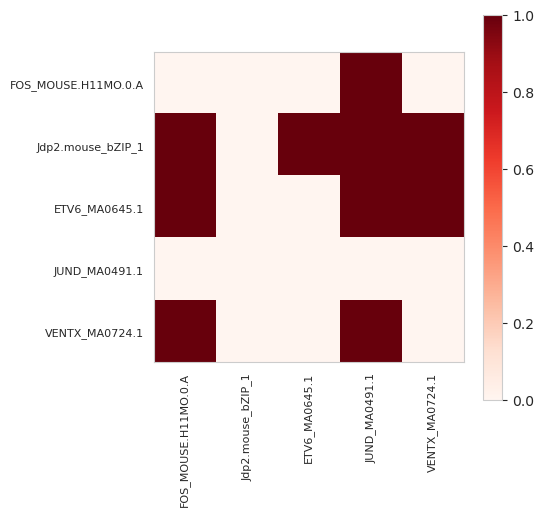

In [25]:
plt.figure(figsize=(5, 5))
plt.imshow(y[r_idxs][:, c_idxs], cmap='Reds', vmin=0, vmax=1)
plt.xticks(range(5), motif_names[:1744][r_idxs], rotation=90, fontsize=8)
plt.yticks(range(5), motif_names[:1744][c_idxs], fontsize=8)
plt.grid(False)
plt.colorbar()
plt.show()

In this matrix, we can see that Jdp2, which is the first returned annotation, fills out every element other than itself, whereas FOS, which is the second to last, only has a connection with JUND, the last element. It is important to keep in mind that the order matters a great deal, so you should make sure that you have ordered the elements correctly according to some notion you care about before setting `symmetric=False`.

#### Pairwise Annotation Spacing

Taking this idea even further, one can consider not only whether pairs of annotations occur in the same examples, but what their *spacings* are. This adds a third dimension of spacing to the tensor, where the first two are annotation indexes. Because calculating spacing requires coordinates, the `pairwise_annotation_spacing` function requires the start (inclusive) and end (non-inclusive) positions of the annotation in addition to the example and annotation indexes. Further, the seqlets must be ordered first by their `example_idx` and then secondly by their `start` position. This reduces the amount of time needed to calculate distance pairs. However, because this can mean changing the order of the seqlets with respect to order of the annotation index vector, you can add the annotations to the seqlet dataframe before sorting and just pass in a four-column dataframe instead.

In [26]:
from tangermeme.annotate import pairwise_annotations_spacing

seqlets['motif_idx'] = motif_idxs[:, 0]
sorted_seqlets  = seqlets.sort_values(['example_idx', 'start'])

y = pairwise_annotations_spacing(sorted_seqlets[['example_idx', 'motif_idx', 'start', 'end']])
y.shape

torch.Size([1744, 1744, 100])

Note the final dimension here of 100. This is the limit on the distance between seqlets within the same example that is allowed. Unfortunately, creating a `(1744, 1744, 2000)` tensor would take up a lot of memory and so the default is lower and seqlet pairs further away from the limit are ignored. If we want to raise the limit we can just pass in an alternate `max_distance`.

In [27]:
y = pairwise_annotations_spacing(sorted_seqlets[['example_idx', 'motif_idx', 'start', 'end']], max_distance=150)
y.shape

torch.Size([1744, 1744, 150])

Now, let's take a look at the returned values. We can't easily visualize this returned tensor but we can return the index along the distance length that pairs were found. Normally, we would want to look at the count values but, here, because that count value will only be 1 (since each motif only appears once) we can just look at the argmax. Again, we will only select the rows and columns of this pairwise matrix corresponding to motifs that were passed in, for convenience of viewing. Let's also print out the motif names that those rows and columns correspond to.

In [28]:
y[r_idxs][:, c_idxs].argmax(axis=-1), motif_names[:1744][c_idxs]

(tensor([[ 0,  0, 56, 21, 15],
         [ 0,  0,  0,  0,  0],
         [56,  0,  0, 21, 86],
         [21,  0, 21,  0, 51],
         [15,  0, 86, 51,  0]]),
 array(['FOS_MOUSE.H11MO.0.A', 'Jdp2.mouse_bZIP_1', 'ETV6_MA0645.1',
        'JUND_MA0491.1', 'VENTX_MA0724.1'], dtype='<U29'))

Now, let's take a peek at the sorted seqlet list to see if this corresponds with our expectations.

In [29]:
sorted_seqlets

,example_idx,start,end,attribution,p-value,motif_idx
2,0,927,942,-0.001295,5.285412e-03,1743
3,0,957,972,0.643915,6.717850e-03,357
4,0,993,1007,0.548725,8.579600e-03,1295
1,0,1028,1044,0.727307,4.798464e-03,1243
0,0,1573,1588,-0.032544,4.662937e-15,639


The first row of our pairwise spacing matrix corresponds to `FOS`. There is no other `FOS` motif and the `Jdp2` motif is too far away to be counted, and so both are 0s in that first row. The third column is `ETV6` and there is, indeed, a 56 bp spacing between the end of the `FOS` motif and the start of the `ETV6` motif.

In [30]:
1028 - 972

56

Next, there is a 26 bp spacing between the start of `JUND` at 993 and the end of `FOS` at 972. Finally, there is a 15 bp spacing between the end of `VENTX` and the start of `FOS` at 957. This point is important: this function will not tell you the relative spacing between the two, just the absolute spacing.